In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import pqcd

from scipy.ndimage import gaussian_filter1d
from universality.gaussianprocess.utils import integrate_phi
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    nsat
    )

Example use of `gaussian_filter1d`

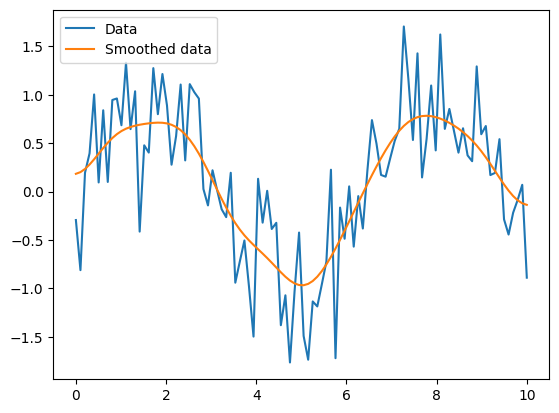

In [2]:
# Example data
times = np.linspace(0, 10, 100)
data = np.sin(times) + np.random.normal(0, 0.5, 100)

# Apply Gaussian filter
sigma = 5  # Standard deviation for Gaussian kernel
smoothed_data = gaussian_filter1d(data, sigma)

fig, ax = plt.subplots()

ax.plot(times, data, label='Data')
ax.plot(times, smoothed_data, label='Smoothed data')

_ = ax.legend()

Create a smooth average of the set 6 EOSs that are consistent with the default pQCD window

In [3]:
set = 6

gp_mean_dict = {}

for variety in ['had', 'hyp', 'qrk']:

    hdf5_path = f'../data/eos-draws-modified/{set:02}/{variety}agn/gpr_gpr_{variety}agn.hdf5'

    gp_mean_dict[variety] = {}

    with h5py.File(hdf5_path, 'r') as f:
        for key in f.keys():

            cov = np.array(f[key]['cov'])
            mean = np.array(f[key]['mean'])

            log_pressure = np.array([entry[0] for entry in mean])
            phi = np.array([entry[1] for entry in mean])

            gp_mean_dict[variety][key] = (log_pressure, phi)

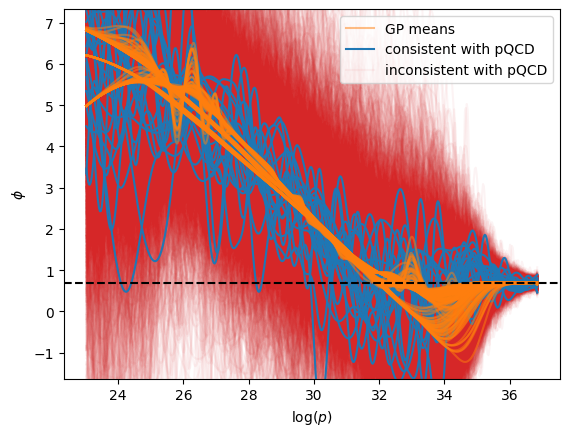

In [4]:
fig, ax = plt.subplots()

consistent_phi_arrays = []
consistent_logp_arrays = []

for variety in ['had', 'hyp', 'qrk']:
    for key in gp_mean_dict[variety].keys():
        log_pressure, phi = gp_mean_dict[variety][key]
        ax.plot(
            log_pressure, 
            phi, c='C1', 
            zorder=2,
            alpha=0.5
            )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

N_samp = 2000

pqcd_region_dict = pqcd.get_pqcd_region()

for variety in ['had', 'hyp', 'qrk']:
    for n in range(N_samp):

        eos = pd.read_csv(
            f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
            )
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            c='C0'
            alpha=1
            zorder=1
            consistent=True
        
        else:
            c='C3'
            alpha=0.05
            zorder=0.5
            consistent=False

        gp = pd.read_csv(
            f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/draw-gpr_{variety}agn-{n:06}.csv', comment='#'
            )
        
        if consistent:
            consistent_phi_arrays.append(gp['phi'].values)
            consistent_logp_arrays.append(gp['log(pressurec2)'].values)
        
        ax.plot(
            gp['log(pressurec2)'],
            gp['phi'],
            color=c,
            alpha=alpha,
            zorder=zorder
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

labels = ['GP means', 'consistent with pQCD', 'inconsistent with pQCD']
handles = [
    plt.Line2D([0], [0], color='C1', alpha=0.5), 
    plt.Line2D([0], [0], color='C0', alpha=1), 
    plt.Line2D([0], [0], color='C3', alpha=0.05)
    ]

ax.legend(handles, labels, loc='upper right')

ax.axhline(np.log(2), c='k', ls='--', zorder=10)

ax.set_xlabel(r'$\log(p)$')
_ = ax.set_ylabel(r'$\phi$')

In [5]:
# The log(p) arrays are all the same
logp_array = consistent_logp_arrays[0]

phi_array = np.array(consistent_phi_arrays)

# First, get an average phi array
mean_phi_array = np.mean(phi_array, axis=0)

# Then, smooth the average phi array
sigma = 20
smoothed_mean_phi_array = gaussian_filter1d(mean_phi_array, sigma)

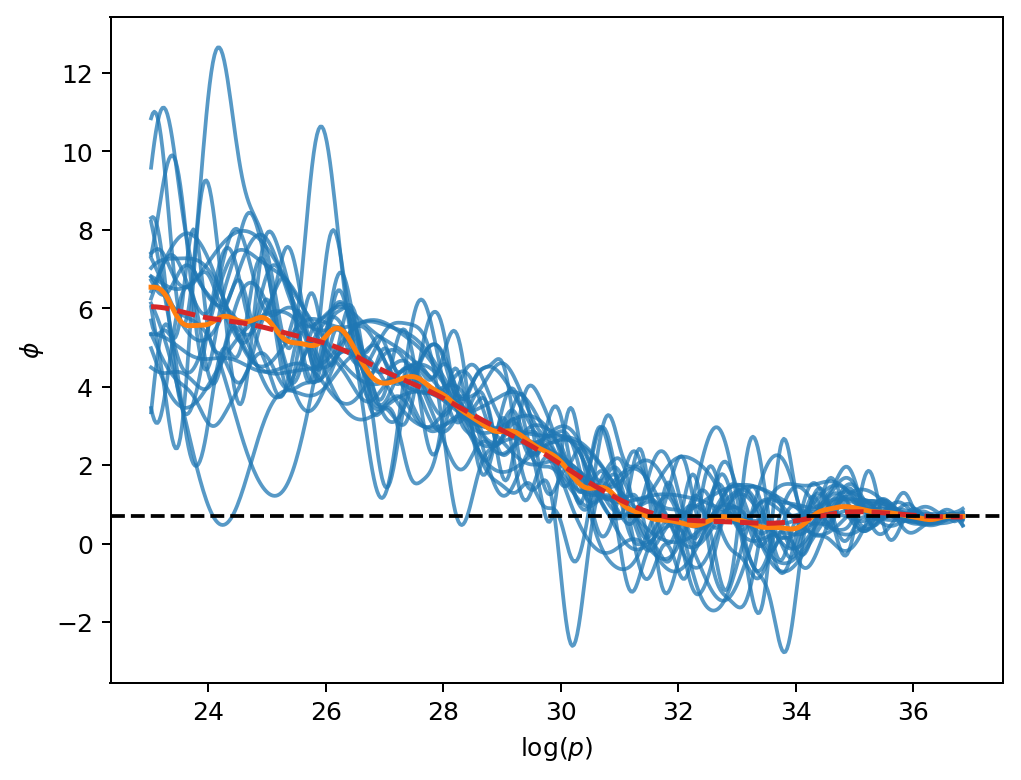

In [6]:
fig, ax = plt.subplots(dpi=180)

for phi_array in consistent_phi_arrays:
    ax.plot(logp_array, phi_array, c='C0', alpha=0.75)

ax.plot(logp_array, mean_phi_array, c='C1', lw=2)

ax.plot(logp_array, smoothed_mean_phi_array, c='C3', lw=2, ls='--')

ax.axhline(np.log(2), c='k', ls='--', zorder=10)

ax.set_xlabel(r'$\log(p)$')
_ = ax.set_ylabel(r'$\phi$')

Now we want to replace the GP mean in set 7 (which was constructed to contain just a single mean) with our new smoothed mean. We don't touch the covariance for now...

In [7]:
hdf5_path = f'../data/eos-draws-modified/07/qrkagn/gpr_gpr_qrkagn.hdf5'

with h5py.File(hdf5_path, 'r') as f:
    
    for key in f.keys():

        # There is only one key
        print(key)

        print()

        print(list(f[key].keys()))
        print(list(f[key].attrs))

        print()

        print(type(f[key]['mean']))
        print(f[key]['mean'])

        mean = np.array(f[key]['mean'])

        log_pressure_default = np.array([entry[0] for entry in mean])
        phi_default = np.array([entry[1] for entry in mean])

0

['cov', 'mean']
['flabel', 'length_scale', 'model_multiplier', 'poly_degree', 'sigma', 'sigma_obs', 'weight', 'xlabel']

<class 'h5py._hl.dataset.Dataset'>
<HDF5 dataset "mean": shape (500,), type "|V16">


In [8]:
# These are basically the same so we don't need to do anything
log_pressure_default - logp_array

array([ 0.00000000e+00, -3.55271368e-15, -3.55271368e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.55271368e-15,  0.00000000e+00,
        3.55271368e-15,  3.55271368e-15,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -3.55271368e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.55271368e-15,  0.00000000e+00,
        3.55271368e-15,  3.55271368e-15,  3.55271368e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.55271368e-15,  0.00000000e+00,  3.55271368e-15,  0.00000000e+00,
       -3.55271368e-15,  3.55271368e-15,  0.00000000e+00,  0.00000000e+00,
        3.55271368e-15,  0.00000000e+00,  3.55271368e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.55271368e-15,
       -3.55271368e-15,  3.55271368e-15,  0.00000000e+00,  0.00000000e+00,
        3.55271368e-15,  0.00000000e+00,  3.55271368e-15,  3.55271368e-15,
        0.00000000e+00,  

In [9]:
# The mean is stored as a list of (logp, phi) tuples
mean

array([(23.02585093, 3.79951584), (23.05353732, 3.83339339),
       (23.08122372, 3.86694223), (23.10891011, 3.90015925),
       (23.13659651, 3.9330414 ), (23.1642829 , 3.96558571),
       (23.19196929, 3.99778927), (23.21965569, 4.02964923),
       (23.24734208, 4.06116284), (23.27502848, 4.09232739),
       (23.30271487, 4.12314023), (23.33040126, 4.15359881),
       (23.35808766, 4.18370063), (23.38577405, 4.21344323),
       (23.41346044, 4.24282426), (23.44114684, 4.27184141),
       (23.46883323, 4.30049244), (23.49651963, 4.32877518),
       (23.52420602, 4.3566875 ), (23.55189241, 4.38422738),
       (23.57957881, 4.41139281), (23.6072652 , 4.43818189),
       (23.6349516 , 4.46459276), (23.66263799, 4.49062361),
       (23.69032438, 4.51627272), (23.71801078, 4.54153842),
       (23.74569717, 4.56641909), (23.77338357, 4.5909132 ),
       (23.80106996, 4.61501924), (23.82875635, 4.63873579),
       (23.85644275, 4.66206149), (23.88412914, 4.68499503),
       (23.91181553, 4.7

In [10]:
# Perhaps meant as a DataFrame?
mean_df = pd.DataFrame(mean)
mean_df

,log(pressurec2),phi
0,23.025851,3.799516
1,23.053537,3.833393
2,23.081224,3.866942
3,23.108910,3.900159
4,23.136597,3.933041
...,...,...
495,36.730616,0.691880
496,36.758302,0.693699
497,36.785989,0.695891
498,36.813675,0.695917


In [11]:
# Replace the phi column of mean_df with the smoothed_mean_phi_array
mean_df['phi'] = smoothed_mean_phi_array
mean_df

,log(pressurec2),phi
0,23.025851,6.038820
1,23.053537,6.037960
2,23.081224,6.036245
3,23.108910,6.033688
4,23.136597,6.030306
...,...,...
495,36.730616,0.679911
496,36.758302,0.679654
497,36.785989,0.679463
498,36.813675,0.679337


In [12]:
# Code from universality.. no need for dataframe?
new_mean = np.empty(len(logp_array), dtype=[('log(pressurec2)', 'float'), ('phi', 'float')])
new_mean['log(pressurec2)'][:] = logp_array
new_mean['phi'][:] = smoothed_mean_phi_array

In [13]:
hdf5_path_copy = 'gpr_gpr_qrkagn_copy.hdf5'

with h5py.File(hdf5_path, 'r') as f_src:
    with h5py.File(hdf5_path_copy, 'w') as f_dest:

        # Copy all the groups and datasets
        f_src.copy('0', f_dest)

        # Delete the original dataset
        del f_dest['0']['mean']

        # Create a new dataset
        f_dest['0'].create_dataset('mean', data=new_mean)

In [14]:
# Check that the copy worked

with h5py.File(hdf5_path_copy, 'r') as f:
        
        for key in f.keys():
    
            # There is only one key
            print(key)
    
            print()
    
            print(list(f[key].keys()))
            print(list(f[key].attrs))
    
            print()
    
            print(type(f[key]['mean']))
            print(f[key]['mean'])
    
            mean = np.array(f[key]['mean'])
    
            log_pressure_edit = np.array([entry[0] for entry in mean])
            phi_edit = np.array([entry[1] for entry in mean])

0

['cov', 'mean']
['flabel', 'length_scale', 'model_multiplier', 'poly_degree', 'sigma', 'sigma_obs', 'weight', 'xlabel']

<class 'h5py._hl.dataset.Dataset'>
<HDF5 dataset "mean": shape (500,), type "|V16">


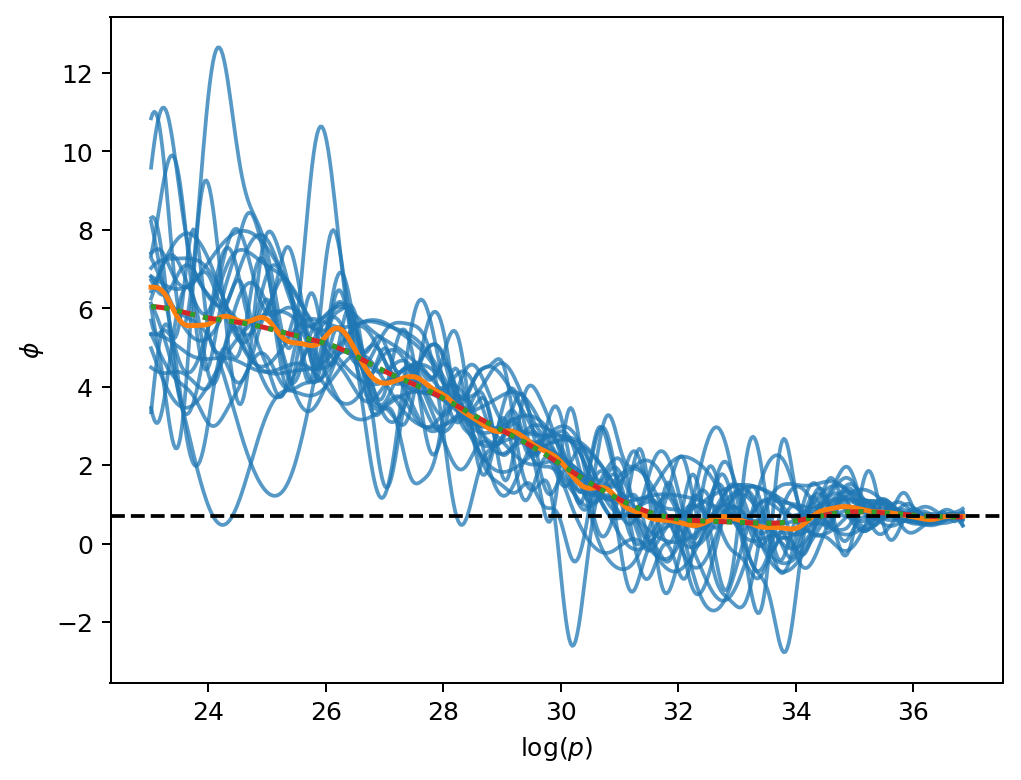

In [15]:
fig, ax = plt.subplots(dpi=180)

for phi_array in consistent_phi_arrays:
    ax.plot(logp_array, phi_array, c='C0', alpha=0.75)

ax.plot(logp_array, mean_phi_array, c='C1', lw=2)

ax.plot(logp_array, smoothed_mean_phi_array, c='C3', lw=2, ls='--')

ax.plot(log_pressure_edit, phi_edit, c='C2', lw=2, ls=':')

ax.axhline(np.log(2), c='k', ls='--', zorder=10)

ax.set_xlabel(r'$\log(p)$')
_ = ax.set_ylabel(r'$\phi$')